# Librerias

In [29]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Carga y preprocesamiento de datos de entrenamiento

In [11]:
train_data = pd.read_csv('train_hora.csv')
train_data['date'] = pd.to_datetime(train_data['date'])
train_data.set_index('date', inplace=True)

scaler_consumption = MinMaxScaler(feature_range=(0, 1))
train_data['consumption_scaled'] = scaler_consumption.fit_transform(train_data['consumption'].values.reshape(-1, 1))

data_combined = train_data[['consumption_scaled']]

# Función Secuencia

In [12]:
def create_sequences(data, seq_length, output_length):
    sequences, targets = [], []
    for i in range(len(data) - seq_length - output_length + 1):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length:i + seq_length + output_length, 0])  
    return np.array(sequences), np.array(targets)


# Datos de Entrenamiento

In [13]:
dias = 7
sequence_length = 24 * dias
output_length = 1

X_train, y_train = create_sequences(data_combined.values, sequence_length, output_length)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
print("Shape de X_train:", X_train.shape)


Shape de X_train: (34896, 168, 1)


# API Funcional

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = LSTM(128, return_sequences=True)(inputs) 
x = Dropout(0.3)(x)
x = LSTM(64, return_sequences=False)(x)
x = Dropout(0.3)(x)
outputs = Dense(output_length)(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 168, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 168, 128)       │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 168, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,033 (453.25 KB)

 Trainable params: 116,033 (453.25 KB)

 Non-trainable params: 0 (0.00 B)

# Datos de Validación

In [15]:
test_data = pd.read_csv('test_hora.csv')
test_data['date'] = pd.to_datetime(test_data['date'])
test_data.set_index('date', inplace=True)

test_data['consumption_scaled'] = scaler_consumption.transform(test_data['consumption'].values.reshape(-1, 1))
test_data_combined = test_data[['consumption_scaled']]


X_val, y_val = create_sequences(test_data_combined.values, sequence_length, output_length)
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

# Entrenamiento del modelo

In [16]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)
model.save('modelo2.keras')

Epoch 1/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 112s 200ms/step - loss: 0.0278 - mae: 0.1129 - val_loss: 0.0027 - val_mae: 0.0392
Epoch 2/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 104s 191ms/step - loss: 0.0056 - mae: 0.0583 - val_loss: 0.0017 - val_mae: 0.0310
Epoch 3/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 100s 183ms/step - loss: 0.0042 - mae: 0.0506 - val_loss: 9.3133e-04 - val_mae: 0.0226
Epoch 4/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 98s 179ms/step - loss: 0.0028 - mae: 0.0409 - val_loss: 7.9913e-04 - val_mae: 0.0194
Epoch 5/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 99s 182ms/step - loss: 0.0022 - mae: 0.0354 - val_loss: 6.7814e-04 - val_mae: 0.0173
Epoch 6/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 99s 181ms/step - loss: 0.0016 - mae: 0.0307 - val_loss: 6.2028e-04 - val_mae: 0.0161
Epoch 7/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 106s 194ms/step - loss: 0.0013 - mae: 0.0263 - val_loss: 6.0395e-04 - val_mae: 0.0159
Epoch 8/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 102s 186ms/step - loss: 9.7499e-04 - mae: 0.0225 - val_loss: 5.1048e-04 - val_mae: 0.0146

# Visualización: Pérdida durante entrenamiento

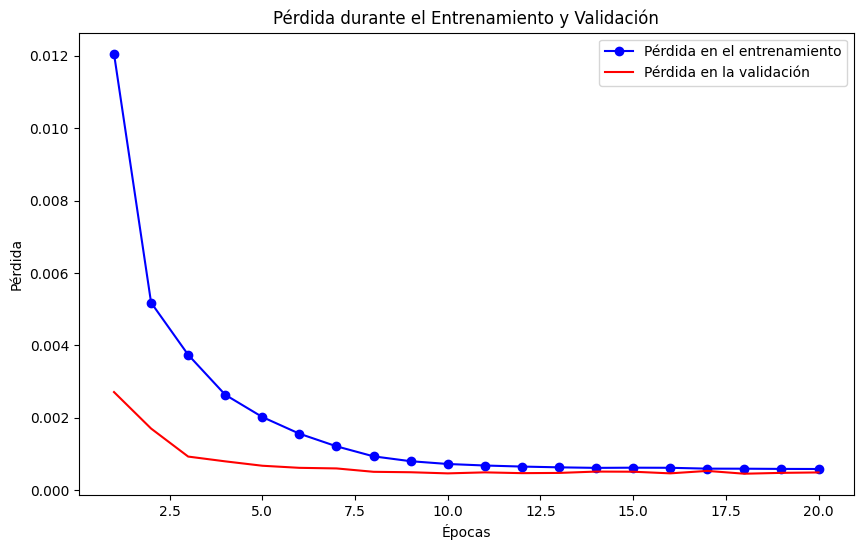

In [17]:
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, 'bo-', label='Pérdida en el entrenamiento')
plt.plot(epochs, val_loss_values, 'r-', label='Pérdida en la validación')
plt.title('Pérdida durante el Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


# Evaluación de Predicciones

In [30]:
def evaluate_model(model, X_test, y_test, scaler):
    predictions = model.predict(X_test)
    predictions_rescaled = scaler.inverse_transform(predictions.reshape(-1, 1))
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
    mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
    rmse = np.sqrt(mse)
    return predictions_rescaled, y_test_rescaled, mae, rmse, mse

predictions_rescaled, y_val_rescaled, mae, rmse, mse = evaluate_model(model, X_val, y_val, scaler_consumption)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

269/269 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step
MAE: 1.5689
MSE: 6.6947
RMSE: 2.5874


In [31]:
predictions_7d = predictions_rescaled[:7 * 24].flatten()
real_values_7d = scaler_consumption.inverse_transform(y_val[:7 * 24].reshape(-1, 1)).flatten()

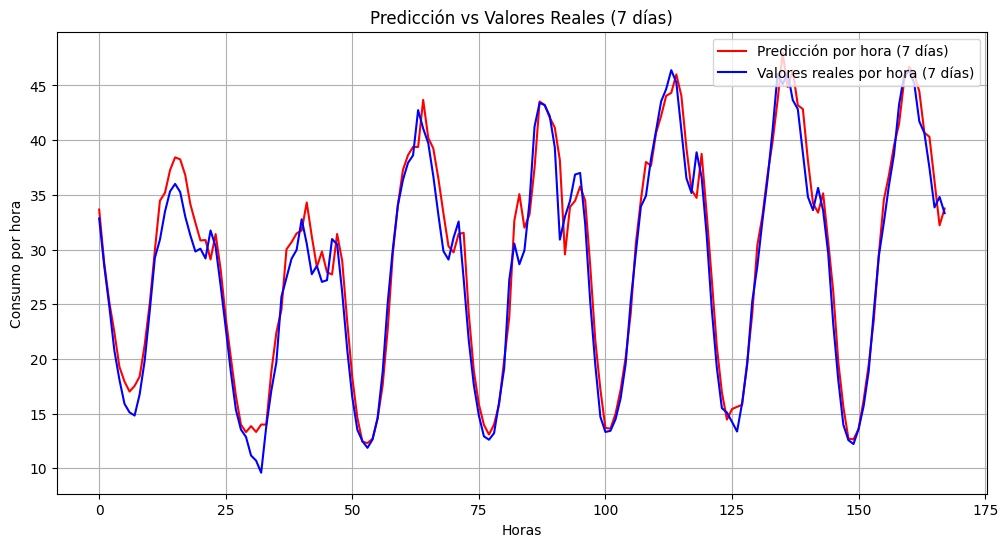

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(predictions_7d, label='Predicción por hora (7 días)', color='red')
plt.plot(real_values_7d, label='Valores reales por hora (7 días)', color='blue')
plt.title('Predicción vs Valores Reales (7 días)')
plt.xlabel('Horas')
plt.ylabel('Consumo por hora')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Visualización: Métricas durante el entrenamiento

In [33]:
mse_train = history.history['loss']
mse_val = history.history['val_loss']

mae_train = history.history['mae']
mae_val = history.history['val_mae']

rmse_train = [np.sqrt(x) for x in mse_train]
rmse_val = [np.sqrt(x) for x in mse_val]

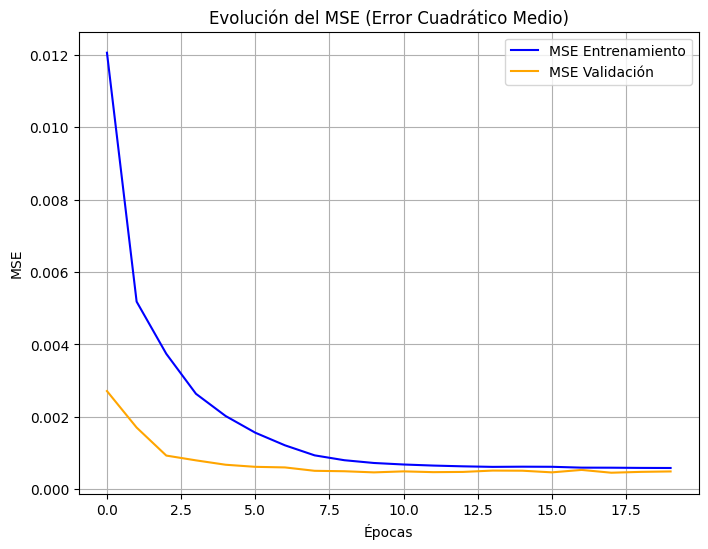

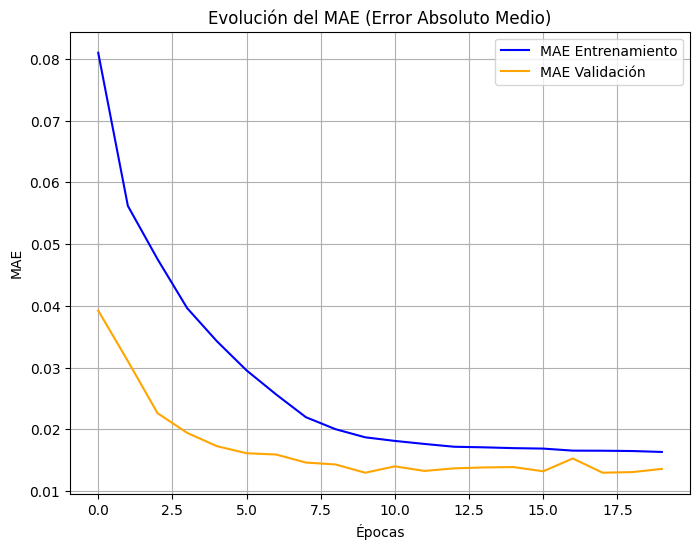

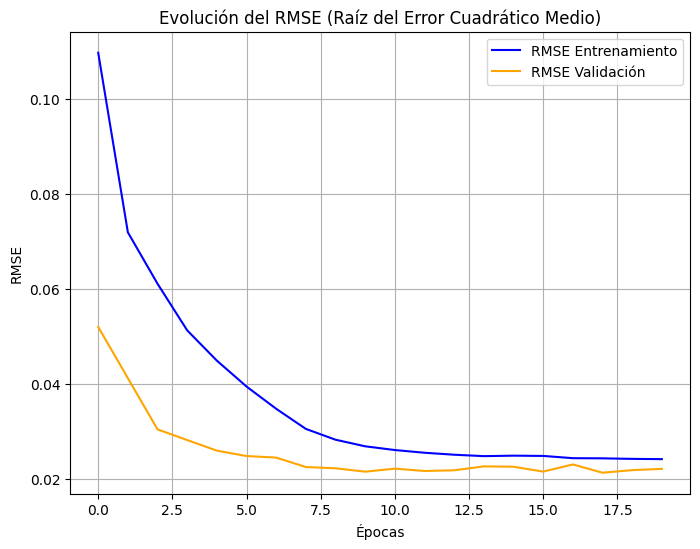

In [34]:
plt.figure(figsize=(8, 6))
plt.plot(mse_train, label='MSE Entrenamiento', color='blue')
plt.plot(mse_val, label='MSE Validación', color='orange')
plt.title('Evolución del MSE (Error Cuadrático Medio)')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(mae_train, label='MAE Entrenamiento', color='blue')
plt.plot(mae_val, label='MAE Validación', color='orange')
plt.title('Evolución del MAE (Error Absoluto Medio)')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(rmse_train, label='RMSE Entrenamiento', color='blue')
plt.plot(rmse_val, label='RMSE Validación', color='orange')
plt.title('Evolución del RMSE (Raíz del Error Cuadrático Medio)')
plt.xlabel('Épocas')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()
